# Summary of endpoint plot for different physics variations

The goal of this plot is to show the change in the 'endpoint fractions' for low vs high Z for all the physics variations explored
I.e., 

$$
\Delta f_{endpoint, i} = f_{endpoint, i}(high Z) - f_{endpoint, i}(low Z)
$$

where i represents the different possible outcomes: Stellar mergers, BBH systems, Merging BBH, BHNS systems, Merging BHNS, NSNS systems, Merging NSNS, WD systems, Massless Remnant, Other



In [9]:
import numpy as np
import os 
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import colorsys

from tkinter import font
from matplotlib.gridspec import GridSpec
from pyrsistent import b

# add run_data path to sys
import sys
sys.path.append('./run_data')
from definitions import sim_flags_dict

home_dir = os.path.expanduser("~") 
compas_v = "v03.01.02" # "v02.46.01/"#v02.35.02/"
datar_root =  f"{home_dir}/ceph/CompasOutput/{compas_v}/"

sim_name =  'NewWinds_RemFryer2012_noMSwinds'#  'NewWinds_RemFryer2012_noNSBHkick'#'OldWinds_RemFryer2012'#  


######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=SMALL_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


# Turn off natural name warning for panda tables (this is due to '@' and '>' in the COMPAS column names)
import warnings
from tables import NaturalNameWarning
warnings.filterwarnings('ignore', category=NaturalNameWarning)

######################################
# Helper function to make color darker
def darken_color(color, factor=0.8):
    r, g, b = (int(color[i:i+2], 16)/255 for i in (1, 3, 5))
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return '#%02x%02x%02x' % tuple(int(x*255) for x in colorsys.hls_to_rgb(h, l*factor, s))



## Start with collecting the data

First define the necessary functions to load the data, and count the relevant numbers/objects

In [12]:
#####################################
# Take the base potential DCO progenitor table
def load_potentialDCO(sim_name, prog_table_name = 'potential_DCO_progenitors_Allinfo.h5'):
    """_summary_

    Args:
        sim_name (str): simulation to load
        prog_table_name (str): name of pot DCO table to load (default ='potential_DCO_progenitors_Allinfo.h5')

    Returns:
        potential_DCO_progenitors, potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors (pandas tables)
    """
    if os.path.isfile(datar_root+ f'/{sim_name}/'+prog_table_name):
        potential_DCO_progenitors = pd.read_hdf(datar_root + f'{sim_name}/' + prog_table_name, key='All_DCO')
        print('Table exists, reading in... ')

        potential_DCO_progenitors.reset_index(drop=True, inplace=True)

        with h5.File(datar_root+f'{sim_name}/COMPAS_Output_combinedZ.h5', 'r') as All_data:
            DCO = All_data['BSE_Double_Compact_Objects']
            st1 = DCO['Stellar_Type(1)'][()]
            st2 = DCO['Stellar_Type(2)'][()]
            dco_merger = DCO['Merges_Hubble_Time'][()]  
            DCO_seed = DCO['SEED'][()]
            # Now I want to add a bool that tells me if this system is ever a BBH, BHNS or BNS progenitor
            BBH_bool = np.logical_and(st1 == 14,st2 == 14)
            BHNS_bool = np.logical_or(np.logical_and(st1 == 13,st2 == 14),
                                    np.logical_and(st1 == 14,st2 == 13) )
            NSNS_bool = np.logical_and(st1 == 13,st2 == 13)
            merger_bool = dco_merger == 1

            # Split our potential DCO progenitors into BBH, BHNS and NSNS progenitors
            potential_BBH_progenitors  = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[BBH_bool*merger_bool]) )]
            potential_BHNS_progenitors = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[BHNS_bool*merger_bool]) )]
            potential_NSNS_progenitors = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[NSNS_bool*merger_bool]) )]

        return potential_DCO_progenitors, potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors

    else:
        print(f'error, {datar_root}/{sim_name}/{prog_table_name} does not exist, you should make it using "DataManipulation.ipynb" first')
        return None, None, None, None

        

#####################################
def get_endpoint_numbers(table):
    """_summary_

    Args:
        table (pandas table): potential_DCO_progenitors

    Returns:
        numpers of systems/events per metallicity
        N_tot_DCO_prog,                             total potential DCO progenitors per Z
        N_unbound, N_mergers,                       The number that is unbound, and the number of stellar mergers
        N_BBH, , N_BHNS, N_NSNS,                    counts of BBH, BHNS, NSNS 
        N_mergingBBH, N_mergingBHNS, N_mergingNSNS  counts BBH, BHNS, NSNS that merge within a Hubble time
        N_WD,                                       systems containing a white dwarf
        N_massless_rem,                             systems containing a massless remnant
        other_bool                                  anything else?
    """

    grouped_byZ = table.groupby('Metallicity@ZAMS(1)')

    N_tot_DCO_prog  = grouped_byZ.size()

    N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
    N_mergers       = grouped_byZ['Merger'].apply(lambda x: (x==1).sum())

    # Make sure all the things below are not unbound or mergers
    not_unbound_nor_merger = np.logical_and(table['Unbound'] == 0, table['Merger'] == 0)
    DCO_merger      = (table['Merges_Hubble_Time'] == 1)

    N_BBH           = grouped_byZ.apply(lambda x: (not_unbound_nor_merger &  np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 14)).sum() ) 
    N_mergingBBH    = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger &  np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 14)).sum() ) 

    N_BHNS          = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
                                                        np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 13))).sum())
    N_mergingBHNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
                                                        np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 13))).sum())

    N_NSNS          = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )
    N_mergingNSNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )

    N_WD            = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_or(x['Stellar_Type(1)'].isin([10, 11, 12]), x['Stellar_Type(2)'].isin([10, 11, 12]))).sum())
    N_massless_rem  =  grouped_byZ.apply(lambda x: (not_unbound_nor_merger &np.logical_or(x['Stellar_Type(1)'] == 15, x['Stellar_Type(2)'] == 15)).sum() ) 


    # IDK whats going on here?
    not_unbound         = table['Unbound'] == 0
    not_merger          = table['Merger'] == 0
    not_BBH             = ~np.logical_and(table['Stellar_Type(1)'] == 14, table['Stellar_Type(2)'] == 14)
    not_NSBH            = ~np.logical_or(np.logical_and(table['Stellar_Type(1)'] == 13, table['Stellar_Type(2)'] == 14),
                                np.logical_and(table['Stellar_Type(1)'] == 14, table['Stellar_Type(2)'] == 13))
    not_NSNS            = ~np.logical_and(table['Stellar_Type(1)'] == 13, table['Stellar_Type(2)'] == 13)
    not_massless_rem    = ~(np.logical_or(table['Stellar_Type(1)'] == 15, table['Stellar_Type(2)'] == 15))
    not_WD              = ~(np.logical_or(table['Stellar_Type(1)'].isin([10, 11, 12]), table['Stellar_Type(2)'].isin([10, 11, 12])))

    other_bool = not_unbound* not_merger * not_BBH * not_NSBH * not_NSNS * not_massless_rem * not_WD
    # Check if there are thing that are both listed as BBH and unbound
    # BBH_and_unbound = (np.logical_and(table['Stellar_Type(1)'] == 14, table['Stellar_Type(2)'] == 14) * (table['Unbound'] == 1)  )
    # print('BBH and unbound', BBH_and_unbound.sum())

    return  N_tot_DCO_prog, N_unbound, N_mergers, N_BBH, N_mergingBBH, N_BHNS, N_mergingBHNS, N_NSNS, N_mergingNSNS, N_WD, N_massless_rem, other_bool




### Now create a class to store all the information we need

this should make the plotting a lot easier and faster

In [11]:
# class to store simulation data
class Simulation:
    def __init__(self, sim_name, label, color, results_table):
        self.sim_name = sim_name
        self.label = label
        self.color = color
        self.results_table = self.collect_results(sim_name)

    def collect_results(self, sim_name = 'NewWinds_RemFryer2012'):
        # Load the potential DCO progenitors
        potential_DCO_progenitors, potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors = load_potentialDCO(sim_name)

        # List of tables of pot DCO progenitors
        titles  = ["All", "BBH", "BHNS", "NSNS"]
        dfs     = [potential_DCO_progenitors, potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors]

        # Initialize an empty dictionary to store the results
        results = {}

        # Loop over the dataframes and titles
        for df, title in zip(dfs, titles):
            print(f' {title} ')
            # Get the results from get_endpoint_numbers
            results[title] = get_endpoint_numbers(table = df)

        return results


# Dictionary to map simulation names to labels and colors we want to use in the plots
label_color_dict = {'NewWinds_RemFryer2012': ['Fiducial', '#515C5D'], 'OldWinds_RemFryer2012': ['Old Winds', '#02926C']}

sim_list = ['NewWinds_RemFryer2012', 'OldWinds_RemFryer2012']#, 'NewWinds_RemMullerMandel', 'NewWinds_RemFryer2012_noBHkick', \
# 'NewWinds_RemFryer2012_noNSBHkick', 'NewWinds_RemFryer2012_noWRwinds', 'NewWinds_RemFryer2012_noMSwinds', 'RemFryer2012_NOwinds']

########################################
# create a list of simulation objects
simulations = []
for sim_name in sim_list:
    print(f'Working on f{sim_name}...')
    label, color = label_color_dict[sim_name]
    sim_obj = Simulation(sim_name, label, color, None)
    simulations.append(sim_obj)



Table exists, reading in... 
BBH and unbound 152638
BBH and unbound 42748
BBH and unbound 9126
BBH and unbound 3324
Table exists, reading in... 
BBH and unbound 139411
BBH and unbound 33959
BBH and unbound 4088
BBH and unbound 401


In [25]:

print(simulations[0].sim_name)

N_tot_DCO_prog, N_unbound, N_mergers, N_BBH, N_mergingBBH, N_BHNS, N_mergingBHNS, N_NSNS, N_mergingNSNS, N_WD, N_massless_rem, other_bool = simulations[0].results_table['BBH'] # get_endpoint_numbers(table = df)

print(N_BBH)
print(N_BBH[0.000100], N_BBH[0.030000])


NewWinds_RemFryer2012
Metallicity@ZAMS(1)
0.000100    8922
0.000173    8170
0.000300    8251
0.000548    9001
0.001000    8931
0.002000    6892
0.004000    4908
0.006325    3193
0.010000    1274
0.014142     991
0.020000     913
0.030000     926
dtype: int64
8922 926


In [ ]:
# Colors
color_dict = {'BBH': '#646873', 
              'BHNS': '#377CB7',#'#4D7DAF', #'#e8485a', 
              'NSNS': '#5FC0B2',#'#8ECCF2', #'#8CBFDA',#'#778FD2',#91c74c',
              'WDWD': '#cfc6c2',
              'masslessRemnants': '#000000',
              'StellarMergers': '#F0C26B', #'#DDBD76'
              'UnboundSystems': '#b0c4dd'} #'#F4C6B9'

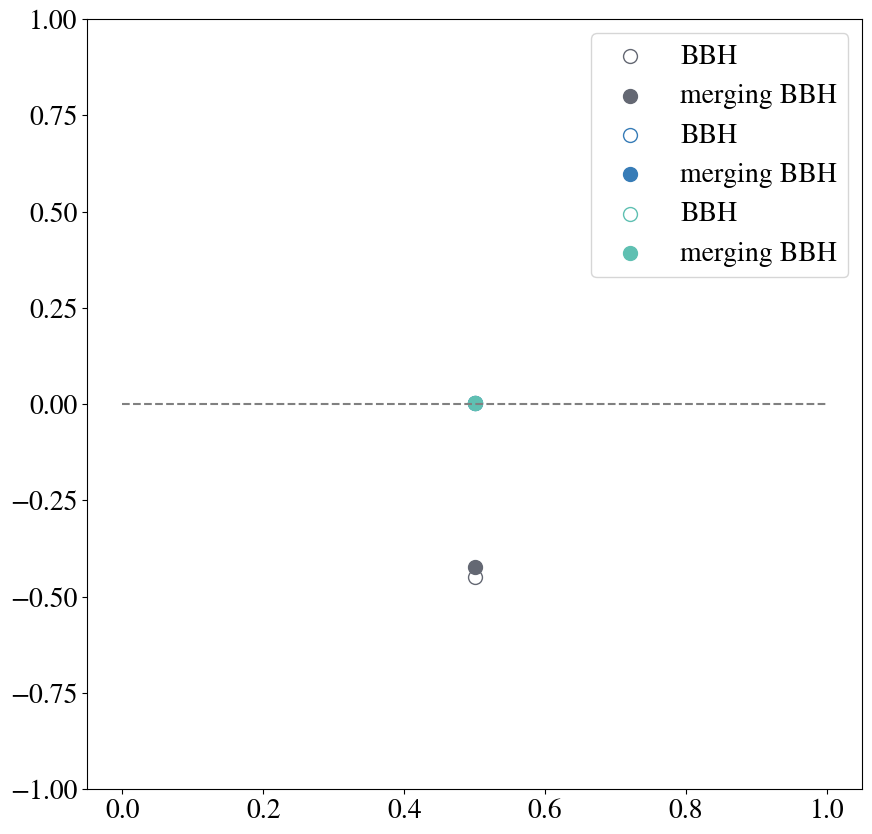

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))

# We will now plot f(highest metallicity) - f(lowest metallicity) / N_tot_DCO_prog
# the key is the metallicity, N_tot_DCO_prog is the same at all Z



# Unbound systems
plt.scatter(0.5, (N_unbound[0.030000] - N_unbound[0.000100])/N_tot_DCO_prog[0.030000], marker='x', color='b0c4dd', s=100, label='Unbound Systems')

# Stellar mergers
plt.scatter(0.5, (N_mergers[0.030000] - N_mergers[0.000100])/N_tot_DCO_prog[0.030000], marker='*', color='#F0C26B', s=100, label='Stellar Mergers')

# (merging) BBH
plt.scatter(0.5, (N_BBH[0.030000] - N_BBH[0.000100])/N_tot_DCO_prog[0.030000], marker='o', edgecolor = '#646873',  color='white', s=100, label='BHBH')
plt.scatter(0.5, (N_mergingBBH[0.030000] - N_mergingBBH[0.000100])/N_tot_DCO_prog[0.030000], marker='o', color='#646873', s=100, label='merging BHBH')

# (merging) BHNS
plt.scatter(0.5, (N_BHNS[0.030000] - N_BHNS[0.000100])/N_tot_DCO_prog[0.030000], marker='o', edgecolor = '#377CB7',  color='white', s=100, label='BHNS')
plt.scatter(0.5, (N_mergingBHNS[0.030000] - N_mergingBHNS[0.000100])/N_tot_DCO_prog[0.030000], marker='o', color='#377CB7', s=100, label='merging BHNS')

# (merging) NSNS
plt.scatter(0.5, (N_NSNS[0.030000] - N_NSNS[0.000100])/N_tot_DCO_prog[0.030000], marker='o', edgecolor = '#5FC0B2',  color='white', s=100, label='NSNS')
plt.scatter(0.5, (N_mergingNSNS[0.030000] - N_mergingNSNS[0.000100])/N_tot_DCO_prog[0.030000], marker='o', color='#5FC0B2', s=100, label='merging NSNS')

# White dwarf systems
plt.scatter(0.5, (N_WD[0.030000] - N_WD[0.000100])/N_tot_DCO_prog[0.030000], marker='*', color='#cfc6c2', s=100, label='WD systems')

# N_massless_rem
plt.scatter(0.5, (N_massless_rem[0.030000] - N_massless_rem[0.000100])/N_tot_DCO_prog[0.030000], marker='O', color='#000000', s=100, label='Stellar Mergers')


N_BBH, N_mergingBBH, 
N_BHNS, N_mergingBHNS,
 N_NSNS, N_mergingNSNS, 
 



ax.hlines(0, 0, 1, linestyle='--', color='gray')
plt.ylim(-1, 1)
plt.legend()
plt.show()